# Fashion GAN (Keras) — Refactored Notebook

This notebook trains a **Generative Adversarial Network (GAN)** on **Fashion-MNIST** to generate synthetic 28×28 grayscale fashion images.

## What you’ll build
- A **Generator** that maps random noise → images
- A **Discriminator** that classifies images as real vs fake
- A **custom training step** that alternates updates to keep training balanced

## Notes
- Training GANs is *visually* evaluated: early samples look like noise.
- This notebook uses `tanh` output and normalizes images to **[-1, 1]** (common GAN convention).


In [1]:
# --- 0) Setup (imports, reproducibility, optional GPU config) ---
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

# Reproducibility (best-effort)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("TensorFlow:", tf.__version__)

# GPU: enable memory growth (prevents TF from reserving all GPU memory)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU available:", gpus)
    except Exception as e:
        print("GPU setup warning:", e)
else:
    print("No GPU found (CPU will be used).")


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1) Configuration

You can tweak these values to trade off speed vs quality.


In [2]:
# --- 1) Configuration ---
IMG_H, IMG_W, IMG_C = 28, 28, 1

LATENT_DIM = 100          # size of random noise vector (try 64/100/128)
BATCH_SIZE = 128
EPOCHS = 20               # increase for better samples (e.g., 200+)
STEPS_PER_EPOCH = None    # leave None to use full dataset
BUFFER_SIZE = 60_000

# Learning rates often matter a lot for GAN stability
GEN_LR  = 2e-4
DISC_LR = 2e-4
BETA_1  = 0.5

SAMPLE_GRID = 5           # 5x5 grid of samples saved every epoch
OUT_DIR = "gan_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


## 2) Dataset (Fashion-MNIST)

We load Fashion-MNIST via `tensorflow_datasets` and create an efficient pipeline:
- normalize to **[-1, 1]**
- shuffle → batch → prefetch


In [3]:
# --- 2) Dataset pipeline ---
def preprocess(example):
    img = tf.cast(example["image"], tf.float32)
    img = img / 127.5 - 1.0   # [0,255] -> [-1,1]
    img = tf.reshape(img, (IMG_H, IMG_W, IMG_C))
    return img

ds = tfds.load("fashion_mnist", split="train", shuffle_files=True)
ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.cache()
ds = ds.shuffle(BUFFER_SIZE, seed=SEED, reshuffle_each_iteration=True)
ds = ds.batch(BATCH_SIZE, drop_remainder=True)
ds = ds.prefetch(tf.data.AUTOTUNE)

print("Dataset ready.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8FW5JD_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8FW5JD_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Dataset ready.


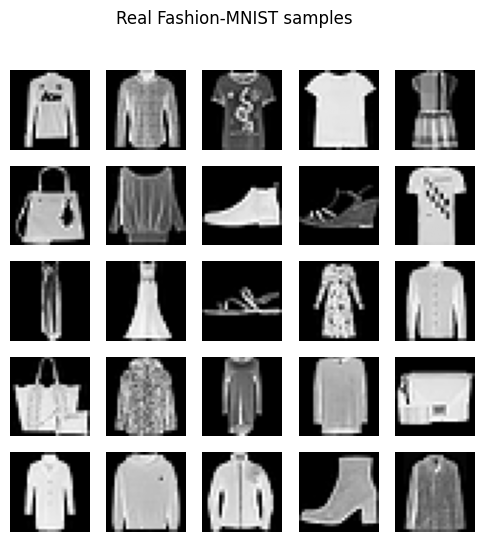

In [4]:
# Quick sanity check: visualize real images
def show_real_samples(dataset, n=25):
    batch = next(iter(dataset))
    imgs = batch[:n].numpy()
    imgs = (imgs + 1.0) / 2.0  # back to [0,1] for display

    grid = int(math.sqrt(n))
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(grid, grid, i+1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle("Real Fashion-MNIST samples")
    plt.show()

show_real_samples(ds, n=SAMPLE_GRID*SAMPLE_GRID)


## 3) Models

### Generator (noise → 28×28×1 image)
We start from a dense layer, reshape to a small feature map, then **upsample using `Conv2DTranspose`**.

### Discriminator (image → real/fake probability)
A CNN binary classifier with dropout for regularization.


In [5]:
# --- 3) Model definitions ---
from tensorflow.keras import layers

def build_generator(latent_dim=LATENT_DIM):
    model = tf.keras.Sequential(name="generator")
    model.add(layers.Input(shape=(latent_dim,)))

    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))  # 7x7x256

    # 7x7 -> 14x14
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 14x14 -> 28x28
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # refine
    model.add(layers.Conv2D(32, kernel_size=3, padding="same"))
    model.add(layers.LeakyReLU())

    # output: tanh -> [-1,1]
    model.add(layers.Conv2D(1, kernel_size=3, padding="same", activation="tanh"))

    return model

def build_discriminator():
    model = tf.keras.Sequential(name="discriminator")
    model.add(layers.Input(shape=(IMG_H, IMG_W, IMG_C)))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # logits (no sigmoid here)

    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,979,457 (7.55 MB)

 Trainable params: 1,953,985 (7.45 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 373,761 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

## 4) Losses + Optimizers

We use **Binary Cross-Entropy with logits** (stable for logits output).

- Discriminator learns to output:
  - **1** for real images
  - **0** for fake images
- Generator learns to make discriminator output **1** on fake images (fool it).

We also add **label smoothing + small noise** to keep the discriminator from becoming overconfident too quickly.


In [6]:
# --- 4) Losses & optimizers ---
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

gen_opt  = tf.keras.optimizers.Adam(learning_rate=GEN_LR, beta_1=BETA_1)
disc_opt = tf.keras.optimizers.Adam(learning_rate=DISC_LR, beta_1=BETA_1)

def discriminator_loss(real_logits, fake_logits):
    # label smoothing for real labels (e.g., 0.9 instead of 1.0)
    real_labels = tf.ones_like(real_logits) * 0.9
    fake_labels = tf.zeros_like(fake_logits)

    real_loss = bce(real_labels, real_logits)
    fake_loss = bce(fake_labels, fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    # generator wants fake to be classified as real (label=1)
    target_labels = tf.ones_like(fake_logits)
    return bce(target_labels, fake_logits)


## 5) Training Step (custom)

Each step:
1. Sample random noise and generate fake images
2. Update **discriminator**
3. Update **generator** (discriminator frozen for this update)

We also optionally train the discriminator **twice per step** (a simple stability trick).


In [7]:
# --- 5) Custom training loop ---
@tf.function
def train_step(real_images, disc_updates=1):
    batch_size = tf.shape(real_images)[0]

    # --- (A) Discriminator updates ---
    for _ in tf.range(disc_updates):
        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as disc_tape:
            fake_images = generator(noise, training=True)

            real_logits = discriminator(real_images, training=True)
            fake_logits = discriminator(fake_images, training=True)

            d_loss = discriminator_loss(real_logits, fake_logits)

        d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # --- (B) Generator update ---
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_logits = discriminator(fake_images, training=False)  # freeze D for G update
        g_loss = generator_loss(fake_logits)

    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


## 6) Sampling utilities

We save a grid of generated images every epoch to visually track progress.


In [8]:
# --- 6) Sampling utilities ---
fixed_noise = tf.random.normal([SAMPLE_GRID*SAMPLE_GRID, LATENT_DIM], seed=SEED)

def save_sample_grid(epoch):
    preds = generator(fixed_noise, training=False)
    imgs = (preds + 1.0) / 2.0  # [-1,1] -> [0,1]

    plt.figure(figsize=(6,6))
    for i in range(SAMPLE_GRID*SAMPLE_GRID):
        plt.subplot(SAMPLE_GRID, SAMPLE_GRID, i+1)
        plt.imshow(imgs[i].numpy().squeeze(), cmap="gray")
        plt.axis("off")

    path = os.path.join(OUT_DIR, f"samples_epoch_{epoch:04d}.png")
    plt.suptitle(f"Generated samples — epoch {epoch}")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()
    print("Saved:", path)


## 7) Train

Start small (e.g., 5 epochs) to verify everything runs, then increase epochs.


Epoch 001 | d_loss=1.2090 | g_loss=1.0942 | time=45.0s


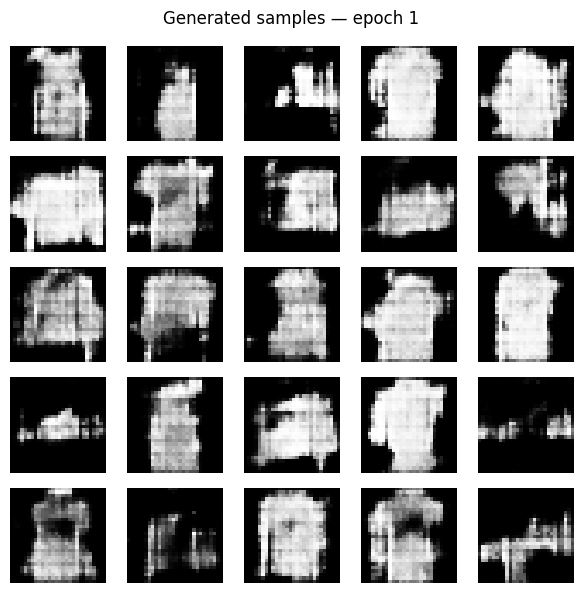

Saved: gan_outputs/samples_epoch_0001.png
Epoch 002 | d_loss=1.1692 | g_loss=1.1867 | time=35.0s


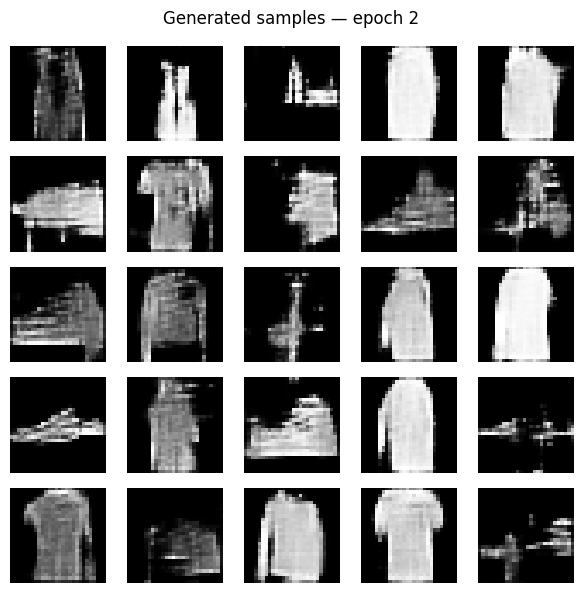

Saved: gan_outputs/samples_epoch_0002.png
Epoch 003 | d_loss=1.2349 | g_loss=1.0690 | time=35.6s


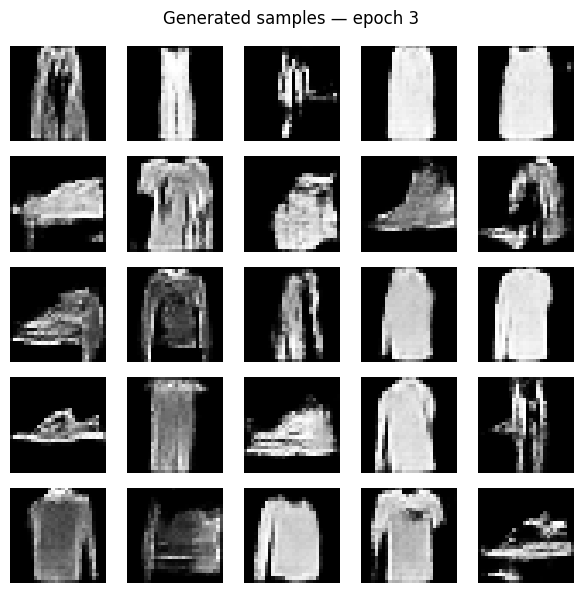

Saved: gan_outputs/samples_epoch_0003.png
Epoch 004 | d_loss=1.2815 | g_loss=0.9984 | time=36.6s


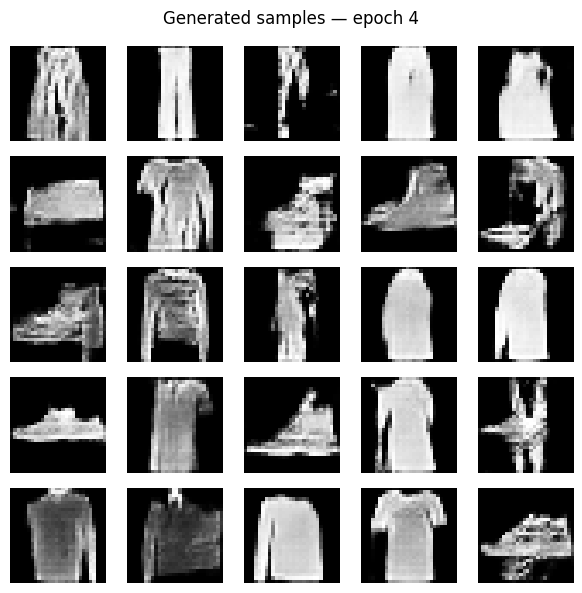

Saved: gan_outputs/samples_epoch_0004.png
Epoch 005 | d_loss=1.2935 | g_loss=0.9836 | time=36.6s


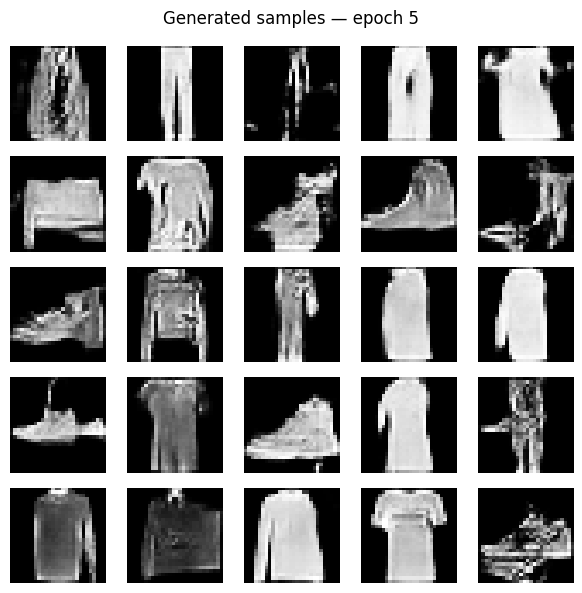

Saved: gan_outputs/samples_epoch_0005.png
Epoch 006 | d_loss=1.3046 | g_loss=0.9697 | time=36.3s


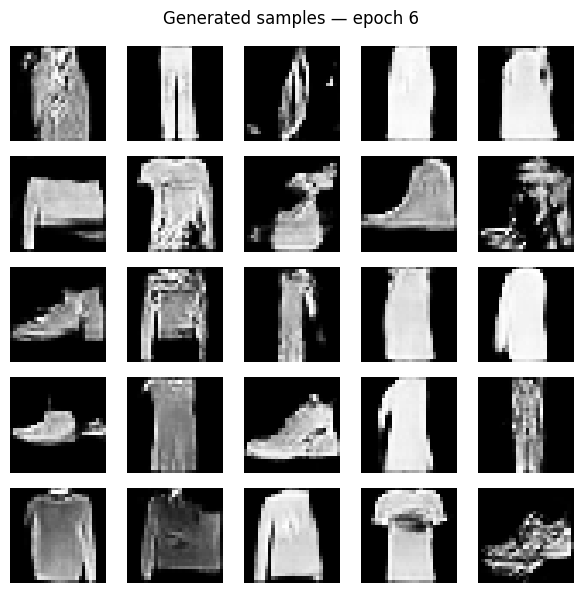

Saved: gan_outputs/samples_epoch_0006.png
Epoch 007 | d_loss=1.3121 | g_loss=0.9506 | time=36.4s


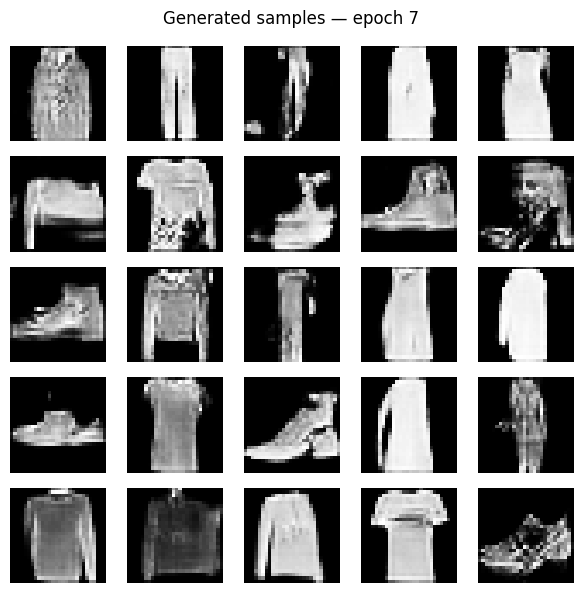

Saved: gan_outputs/samples_epoch_0007.png
Epoch 008 | d_loss=1.3140 | g_loss=0.9391 | time=36.3s


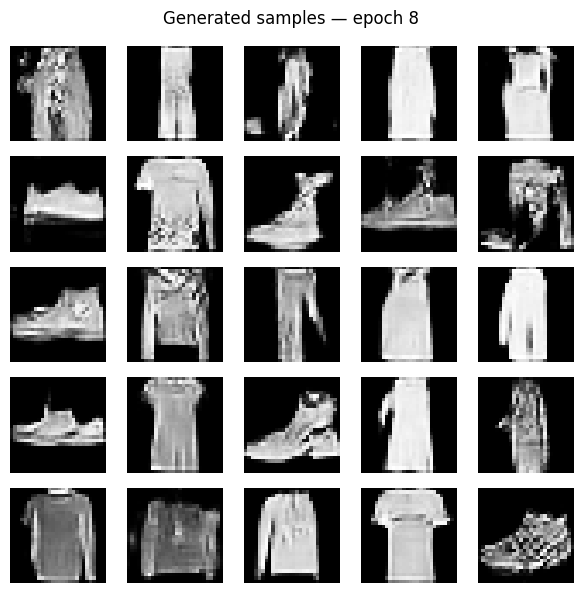

Saved: gan_outputs/samples_epoch_0008.png
Epoch 009 | d_loss=1.3174 | g_loss=0.9307 | time=36.3s


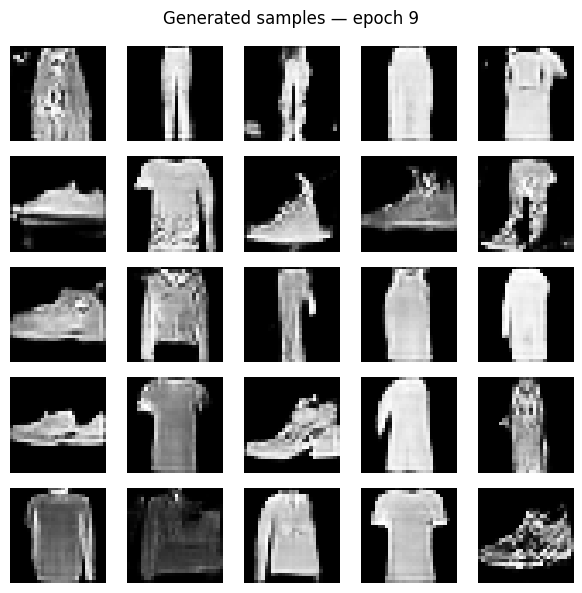

Saved: gan_outputs/samples_epoch_0009.png
Epoch 010 | d_loss=1.3185 | g_loss=0.9238 | time=36.5s


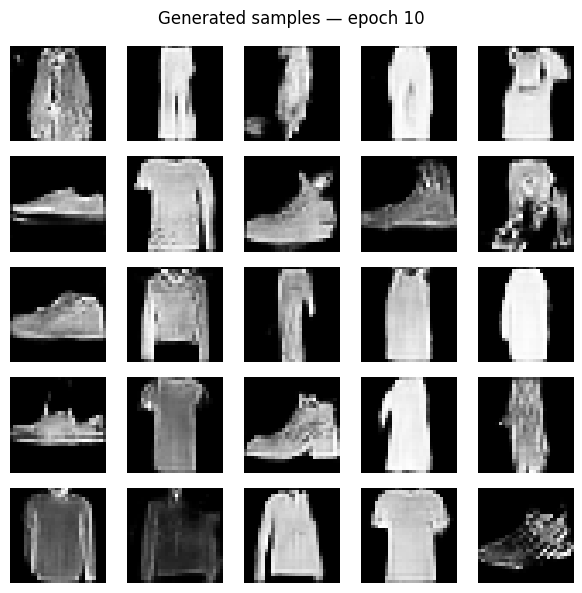

Saved: gan_outputs/samples_epoch_0010.png
Epoch 011 | d_loss=1.3220 | g_loss=0.9157 | time=36.3s


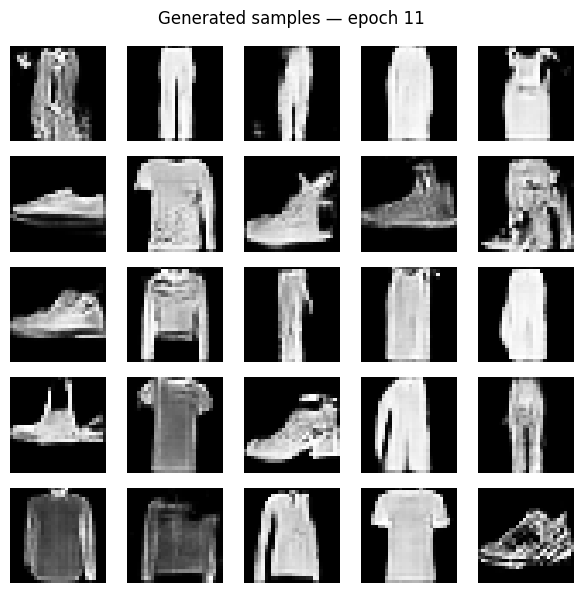

Saved: gan_outputs/samples_epoch_0011.png
Epoch 012 | d_loss=1.3230 | g_loss=0.9154 | time=36.4s


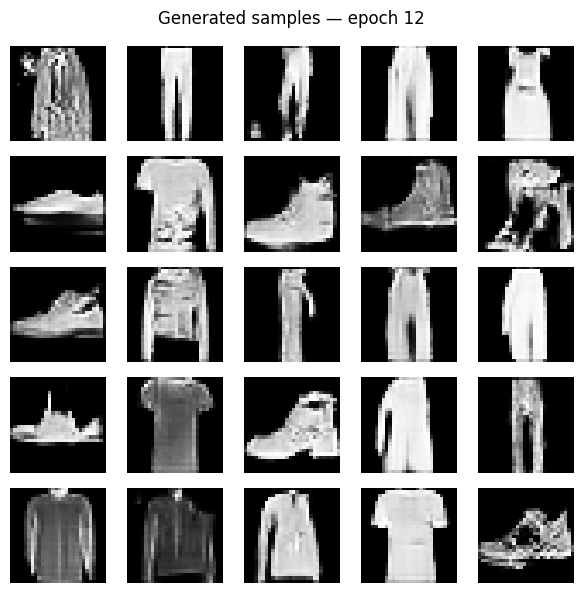

Saved: gan_outputs/samples_epoch_0012.png
Epoch 013 | d_loss=1.3250 | g_loss=0.9112 | time=36.5s


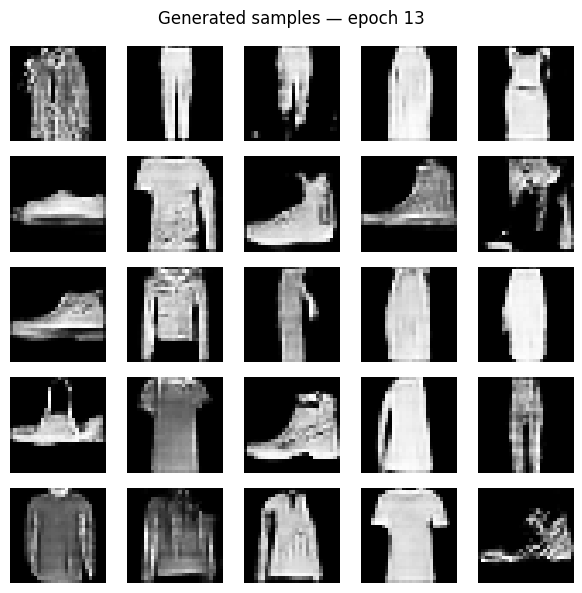

Saved: gan_outputs/samples_epoch_0013.png
Epoch 014 | d_loss=1.3257 | g_loss=0.9089 | time=36.3s


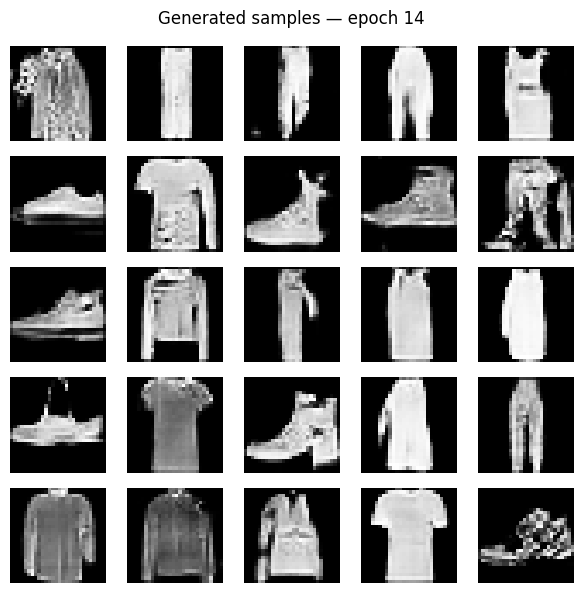

Saved: gan_outputs/samples_epoch_0014.png
Epoch 015 | d_loss=1.3294 | g_loss=0.8992 | time=36.5s


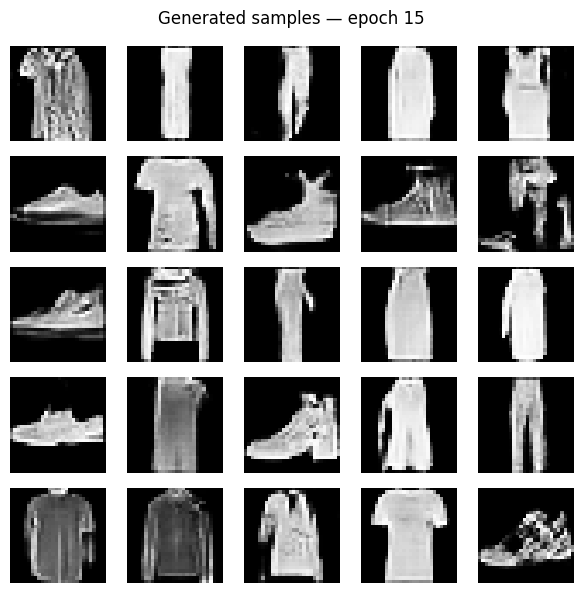

Saved: gan_outputs/samples_epoch_0015.png
Epoch 016 | d_loss=1.3297 | g_loss=0.8968 | time=36.4s


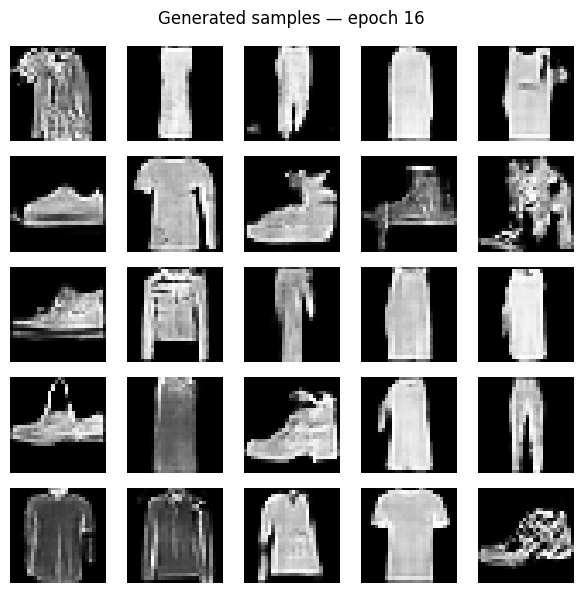

Saved: gan_outputs/samples_epoch_0016.png
Epoch 017 | d_loss=1.3300 | g_loss=0.8968 | time=36.5s


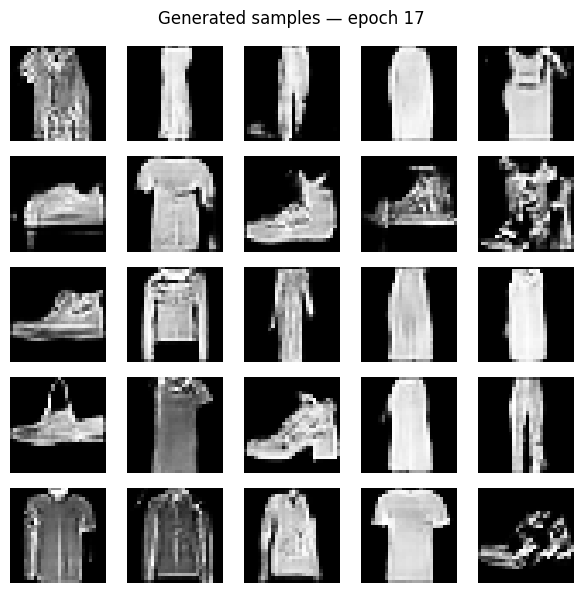

Saved: gan_outputs/samples_epoch_0017.png
Epoch 018 | d_loss=1.3303 | g_loss=0.8992 | time=36.4s


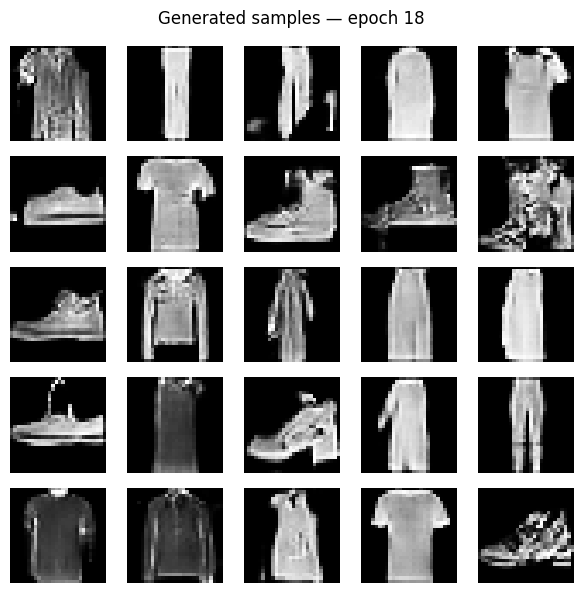

Saved: gan_outputs/samples_epoch_0018.png
Epoch 019 | d_loss=1.3330 | g_loss=0.8953 | time=36.4s


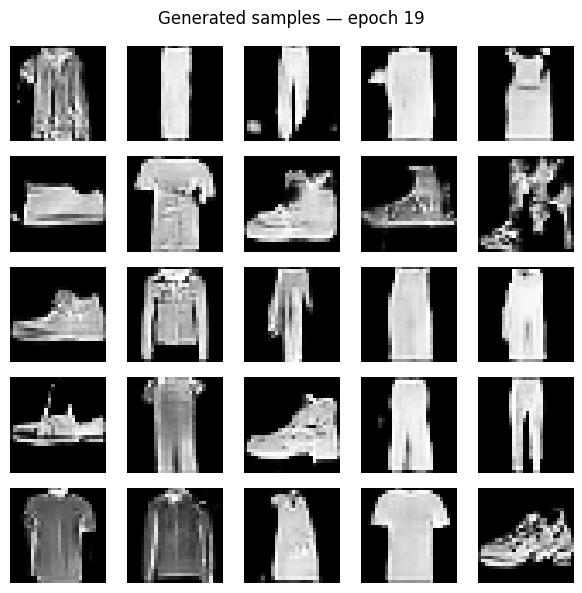

Saved: gan_outputs/samples_epoch_0019.png
Epoch 020 | d_loss=1.3346 | g_loss=0.8956 | time=36.5s


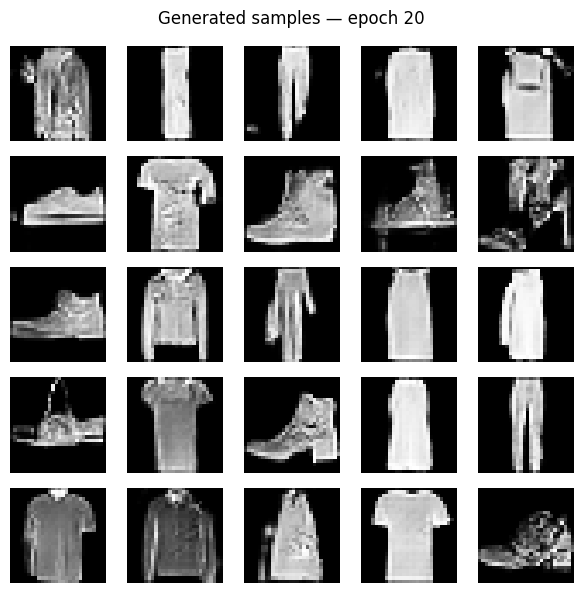

Saved: gan_outputs/samples_epoch_0020.png


In [9]:
# --- 7) Training loop ---
def train(dataset, epochs=EPOCHS, disc_updates=1, steps_per_epoch=STEPS_PER_EPOCH):
    history = {"d_loss": [], "g_loss": []}

    for epoch in range(1, epochs+1):
        t0 = time.time()
        d_loss_avg = tf.keras.metrics.Mean()
        g_loss_avg = tf.keras.metrics.Mean()

        for step, real_images in enumerate(dataset):
            d_loss, g_loss = train_step(real_images, disc_updates=disc_updates)
            d_loss_avg.update_state(d_loss)
            g_loss_avg.update_state(g_loss)

            if steps_per_epoch is not None and (step + 1) >= steps_per_epoch:
                break

        history["d_loss"].append(float(d_loss_avg.result().numpy()))
        history["g_loss"].append(float(g_loss_avg.result().numpy()))

        print(f"Epoch {epoch:03d} | d_loss={history['d_loss'][-1]:.4f} | g_loss={history['g_loss'][-1]:.4f} | time={time.time()-t0:.1f}s")

        # Save samples each epoch
        save_sample_grid(epoch)

    return history

history = train(ds, epochs=EPOCHS, disc_updates=2)


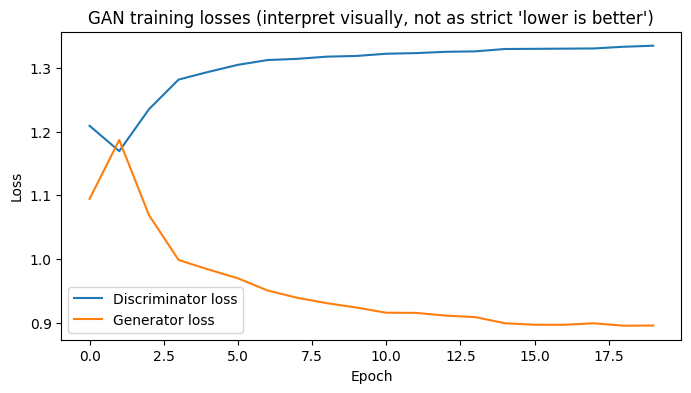

In [10]:
# Plot loss curves
plt.figure(figsize=(8,4))
plt.plot(history["d_loss"], label="Discriminator loss")
plt.plot(history["g_loss"], label="Generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN training losses (interpret visually, not as strict 'lower is better')")
plt.show()


## 8) Save / Load Weights

Useful for resuming training without starting over.


In [11]:
# --- 8) Save / load ---
WEIGHTS_DIR = os.path.join(OUT_DIR, "weights")
os.makedirs(WEIGHTS_DIR, exist_ok=True)

gen_path  = os.path.join(WEIGHTS_DIR, "generator.weights.h5")
disc_path = os.path.join(WEIGHTS_DIR, "discriminator.weights.h5")

def save_weights():
    generator.save_weights(gen_path)
    discriminator.save_weights(disc_path)
    print("Saved weights to:", WEIGHTS_DIR)

def load_weights():
    if os.path.exists(gen_path) and os.path.exists(disc_path):
        generator.load_weights(gen_path)
        discriminator.load_weights(disc_path)
        print("Loaded weights from:", WEIGHTS_DIR)
    else:
        print("No weights found yet. Train first, then save.")

# Example:
# save_weights()
# load_weights()
